In [2]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import dfols
import signal
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate, integrate
from stopit import threading_timeoutable as timeoutable
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from batfuns import *
plt.rcParams = set_rc_params(plt.rcParams)
import winsound
from pybamm import exp, constants, Parameter
import pickle
eSOH_DIR = "../data/esoh_R/"
oCV_DIR = "../data/ocv/"
cyc_DIR = "../data/cycling/"
fig_DIR = "../figures/figures_paper/"
res_DIR = "../data/results_paper/"
resistance_DIR = "../data/resistance/"
%matplotlib widget

In [4]:
parameter_values = get_parameter_values()

spm = pybamm.lithium_ion.SPM(
    {
        "SEI": "ec reaction limited",
        "loss of active material": "stress-driven",
        "lithium plating": "irreversible",
        "stress-induced diffusion": "false",
    }
)
# spm.print_parameter_info()
param=spm.param

In [5]:
cell = 10
sno = 15
sim_des = f'cond{sno}'
cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
Ns = np.insert(N[1:]-1,0,0)

In [6]:
def load_cycling_data(cell,eSOH_DIR,oCV_DIR,cyc_DIR,cyc_no):
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    cycles = np.array(dfe_0['N'].astype('int'))+1
    cycles = cycles[1:]
    # print(cell_no)
    cyc_data_raw1 = pd.read_csv(cyc_DIR+'cycling_data_cell_'+cell_no+'.csv')
    if len(cycles) == cyc_no+1:
        N1 = cyc_data_raw1["Cycle number"].iloc[-2]-2
    else:
        N1 = cycles[cyc_no]
    print(N1)
    cyc_data_raw = cyc_data_raw1[ cyc_data_raw1['Cycle number'] == N1 ]
    cyc_data = cyc_data_raw.reset_index(drop=True)
    t_c1 = cyc_data['Time [s]']-cyc_data['Time [s]'][0]
    t_c1 = t_c1.values
    I_c1 = cyc_data['Current [mA]']/1000
    I_c1 = I_c1.values
    V_c1 = cyc_data['Voltage [V]']
    V_c1 = V_c1.values
    E_c1 = cyc_data["Expansion [mu m]"]
    E_c1 = E_c1.values
    idx_I = np.where(np.sign(I_c1[:-1]) != np.sign(I_c1[1:]))[0] 
    idx_I = idx_I[idx_I>50]
    t = t_c1
    V = V_c1
    I = I_c1
    E = E_c1-E_c1[0]
    # t = t_c1
    # V = V_c1
    # I = I_c1
    Q = integrate.cumtrapz(I,t, initial=0)/3600 #Ah
    
    return t,V,I,Q,E


In [7]:
cyc_no = 0 
min_E = []
max_E = []
cyc_data_raw1 = pd.read_csv(cyc_DIR+'cycling_data_cell_'+cell_no+'.csv')
cyc_data_raw2 = cyc_data_raw1[ cyc_data_raw1['Cycle number'] == 41+cyc_no ]
E_c0 = cyc_data_raw2["Expansion [mu m]"]
E_c0 = E_c0.values
E_0 = 54.8 
for cyc_no in range(N[-1]):
    cyc_data_raw = cyc_data_raw1[ cyc_data_raw1['Cycle number'] == 41+cyc_no ]
    E_c1 = cyc_data_raw["Expansion [mu m]"]
    E_c1 = E_c1.values
    E_c1 = E_c1 - E_0
    min_E.append(min(E_c1))
    max_E.append(max(E_c1))

In [8]:
N_all = np.arange(0,N[-1])

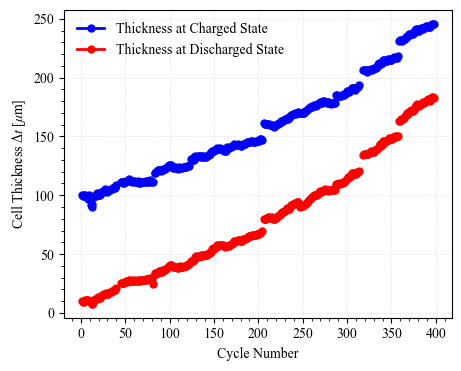

In [15]:
fig ,ax = plt.subplots(1,1, figsize=(5,4))
ax1 = ax
ax1.plot(N_all,max_E,'b-o')
ax1.plot(N_all,min_E,'r-o')
ax1.set_xlabel('Cycle Number')
ax1.set_ylabel('Cell Thickness $\Delta t$ [$\mu$m]')
ax1.legend(["Thickness at Charged State", 'Thickness at Discharged State'])
plt.savefig(fig_DIR +'max_min_exp_cell_'+cell_no+'.png')

In [10]:
df = pd.read_csv(res_DIR + "DC_resistance_cell_"+cell_no+".csv")
# ax.plot(df["Ah_th"],(df["Rs_data"]-df["Rs_data"][0])/df["Rs_data"][0]*100,linestyle="None",marker="o",label='_nolegend_',color=colors[i])

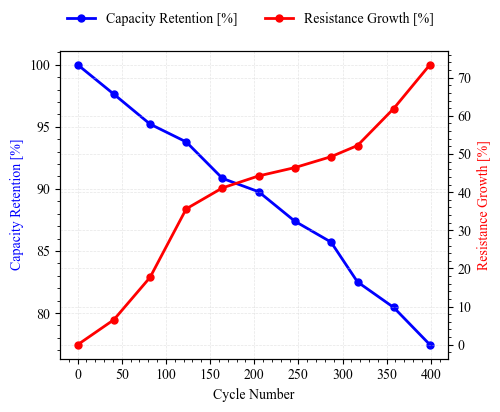

In [13]:
cap_data = dfe["Cap"]/dfe["Cap"][0]*100
fig ,ax = plt.subplots(1,1, figsize=(5,4))
ax1 = ax
ax1.plot(dfe["N"],cap_data,"bo-")
ax1.set_xlabel("Cycle Number")
ax1.set_ylabel(r"Capacity Retention [%]",color="blue")
ax2 = ax1.twinx()
ax2.plot(df["N"],(df["Rs_data"]-df["Rs_data"][0])/df["Rs_data"][0]*100,"-o",color="red")
ax2.set_ylabel(r'Resistance Growth [%]',color="red")
fig.legend(["Capacity Retention [%]", 'Resistance Growth [%]'],loc="upper center",ncol=2)
plt.savefig(fig_DIR +'cap_resistance_exp_cell_'+cell_no+'.png')